In [3]:
import random
import sys

import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn

from config import Config
from data import *
from models import *
from train import *
from run import setup_seed

sys.path.insert(0, "./src")

In [4]:
setup_seed(12)

In [5]:
DATA_PATH = "./data/PSI_Biology_solubility_trainset.csv"
SAVE_MODEL_DIR = "./models/"
SAVE_MODEL_PREFIX = "cnn_"
LOAD_MODEL_PATH = None  # E.g. "./models/cnn_1"

In [6]:
config = Config.params

model_conf = {
    "embed": [20, 2],
    "cnn": [
        # in_channels, out_channels, kernel_size, dropout_p
        [2, 2, 3, 0.2],
        [2, 2, 3, 0.2],
    ],
    "linear": [
        # in_features, #out_features, dropout_p
        [config["max_chain_length"] * 2, config["max_chain_length"], 0.2],
    ],
}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
data = init_data(DATA_PATH, device, config["max_chain_length"])

In [10]:
model = Model3(model_conf)
model.to(device)

Model3(
  (embed): EmbedLayer(
    (linear): Linear(in_features=20, out_features=2, bias=True)
  )
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1620, out_features=810, bias=True)
      (bn): BatchNorm1d(810, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (fc): Linear(in_features=810, o

In [11]:
# Load pretrained weights
if LOAD_MODEL_PATH != None:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH))

In [12]:
optimiser = torch.optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"],
)

In [13]:
criterion = nn.BCEWithLogitsLoss(pos_weight=data["neg_pos_ratio"]).to(device)

In [14]:
# Training
for e in range(1, 101):
    train_epoch(data, model, optimiser, criterion, config["batch_size"])

    # Evaluation
    if e % config["eval_step"] == 0:
        eval_model(e, data, model, optimiser, criterion)

        model.train()
        torch.save(model.state_dict(), SAVE_MODEL_DIR + SAVE_MODEL_PREFIX + str(e))

Epoch 10 - Train loss: 0.333; Test loss: 0.464
Accuracy: 0.656
Precision: 0.742
Recall: 0.742
Pred. STD: 0.232
F1: 0.739
ROC AUC: 0.673
Epoch 20 - Train loss: 0.200; Test loss: 0.570
Accuracy: 0.652
Precision: 0.797
Recall: 0.716
Pred. STD: 0.279
F1: 0.749
ROC AUC: 0.651
Epoch 30 - Train loss: 0.208; Test loss: 0.838
Accuracy: 0.675
Precision: 0.863
Recall: 0.703
Pred. STD: 0.286
F1: 0.781
ROC AUC: 0.650
Epoch 40 - Train loss: 0.106; Test loss: 0.745
Accuracy: 0.656
Precision: 0.757
Recall: 0.735
Pred. STD: 0.338
F1: 0.743
ROC AUC: 0.646
Epoch 50 - Train loss: 0.110; Test loss: 0.953
Accuracy: 0.671
Precision: 0.840
Recall: 0.709
Pred. STD: 0.319
F1: 0.774
ROC AUC: 0.641
Epoch 60 - Train loss: 0.149; Test loss: 1.228
Accuracy: 0.677
Precision: 0.863
Recall: 0.704
Pred. STD: 0.311
F1: 0.784
ROC AUC: 0.643
Epoch 70 - Train loss: 0.190; Test loss: 1.535
Accuracy: 0.678
Precision: 0.907
Recall: 0.691
Pred. STD: 0.257
F1: 0.793
ROC AUC: 0.623
Epoch 80 - Train loss: 0.119; Test loss: 1.376
A

In [15]:
model.eval()

Model3(
  (embed): EmbedLayer(
    (linear): Linear(in_features=20, out_features=2, bias=True)
  )
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,), padding=same)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=1620, out_features=810, bias=True)
      (bn): BatchNorm1d(810, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (silu): SiLU()
    )
  )
  (fc): Linear(in_features=810, o

In [16]:
test_in = torch.eye(20).to(device)

In [17]:
output = model.embed.linear(test_in).cpu().detach().numpy()
output

array([[ 0.14751872,  0.02105792],
       [-0.3666431 , -0.4732764 ],
       [ 0.13663512, -0.06950518],
       [ 0.24615222,  0.19545817],
       [-0.20143075, -0.09249628],
       [-0.00457574, -0.08208321],
       [ 0.07112665, -0.27200526],
       [-0.06244748, -0.05073382],
       [ 0.3230949 ,  0.08518378],
       [-0.05729573, -0.09372725],
       [-0.125236  , -0.2047911 ],
       [ 0.10060732,  0.08108701],
       [ 0.06368688, -0.14153484],
       [ 0.09275451, -0.24217147],
       [ 0.06287052, -0.1886381 ],
       [-0.13570967, -0.19756563],
       [ 0.39019632, -0.11861058],
       [ 0.07680587, -0.13817737],
       [-0.15417466, -0.22677551],
       [-0.14708325, -0.05652157]], dtype=float32)

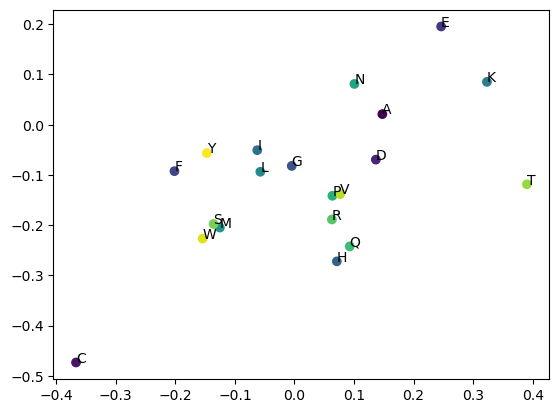

In [18]:
plt.scatter(output[:, 0], output[:, 1], c=range(20))
for i in range(20):
    plt.annotate(residues[i], (output[i, 0], output[i, 1]))